In [1]:
filename = "../../../Kr83m_tpc_gaseous_lutz_150522_coin1_th300_6.hdf5"
file_format='hdf5'

In [2]:
import logging
log = logging.getLogger('AnalysisExample')
log.setLevel('DEBUG')

import numpy as np

import matplotlib   # Needed for font size spec, color map transformation function bla bla
%matplotlib inline
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    log.debug("You don't have tqdm, I can't give you a nice progress bar...")
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

from recarray_tools import append_fields, fields_view, group_by, filter_on_fields, fields_data

peak_types = [b's1', b's2', b'unknown', b'noise', b'lone_hit']

In [3]:
##
# Load the data
##

log.debug("Now loading %s (file format=%s)..." % (filename, file_format))

# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
try:
    # Load the file using pax 3's IO code
    from pax.formats import flat_data_formats
    ioformat = flat_data_formats[file_format]()
    ioformat.open(filename, 'r')
    events = ioformat.read_data('Event')
    peaks = ioformat.read_data('Peak')
    ioformat.close()
except ImportError:
    log.debug("You don't have pax 3 installed, falling back to HDF5-specific code...")
    import h5py
    f = h5py.File(filename)
    events = f.get('Event')[:]
    peaks = f.get('Peak')[:]
    f.close()

log.info("Loaded %s, containing %d peaks (%0.2f MB RAM) and %d events (%0.2f MB RAM)" % (
    filename, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))
if len(events) == 0:
    raise ValueError("You don't have any events in this dataset!")

DEBUG:AnalysisExample:Now loading ../../../Kr83m_tpc_gaseous_lutz_150522_coin1_th300_6.hdf5 (file format=hdf5)...
INFO:AnalysisExample:Loaded ../../../Kr83m_tpc_gaseous_lutz_150522_coin1_th300_6.hdf5, containing 243221 peaks (85.61 MB RAM) and 141247 events (54.24 MB RAM)


In [4]:
##
# Hacks
##

# Get the sample duration for conversions from samples -> time
dt = events[0]['sample_duration']

# Get rid pathological events without peaks immediately, later code doesn't work on these ...
n_before = len(events)
events = filter_on_fields(events, peaks, 'Event')
log.debug("Deleted %d events without any peaks (%0.4f%% of total)" % (
    n_before-len(events), 100*(n_before-len(events))/n_before))

# Hack for XAMS: Correct for pmt top/bottom swap in config
# peaks['area_fraction_top'] = 1 - peaks['area_fraction_top']

DEBUG:AnalysisExample:Deleted 2526 events without any peaks (1.7884% of total)


In [5]:
##
# Add extra peak fields here
##

# Add full_range peak width
peaks = append_fields(peaks, 'full_range', (peaks['right'] - peaks['left'] + 1)*dt)
peaks = append_fields(peaks, 'skew', -1 + 2* (peaks['hit_time_mean'] - peaks['left']*dt)/peaks['full_range'])

In [6]:
##
# Add n_S1, n_S2, ... in each event
##

# Group peaks by event
peaks_per_event = group_by(peaks, 'Event')
assert len(peaks_per_event) == len(events)

# Add total number of peaks
events = append_fields(events,
                       'nof_peaks',
                       np.array([len(x) for x in peaks_per_event]))

# Add number of individual peak types
for pt in peak_types:
    events = append_fields(events,
                           'n_'+pt.decode(),
                           np.array([len(x[x['type'] == pt]) for x in peaks_per_event]))

In [7]:
##
# Select events with >=1 S1 and >=1 S2
##
n_before = len(events)
cut = (events['n_s1'] >= 1) & (events['n_s2'] >= 1)
events = events[cut]
peaks_per_event = [x for i, x in enumerate(peaks_per_event) if cut[i]]

log.debug("%0.2f%% of events have >=1 S1 and S2, keeping only those." % (100*len(events)/n_before))

DEBUG:AnalysisExample:1.04% of events have >=1 S1 and S2, keeping only those.


In [8]:
##
# Add s1_... and s2_... fields to event
# This way you can access all properties of the main S1 and S2 directly from the event
##
ignore_fields = ['Event', 'Peak', 'type',
                 # recfunctions have trouble with subarrays...
                 'does_channel_contribute', 'does_channel_have_noise', 'area_per_channel']
for pt in (b's1', b's2'):
    main_peaks = []
    for pks in tqdm(peaks_per_event, desc='Selecting %ss' % pt.decode()):
        peaks_of_this_type =  pks[pks['type'] == pt]
        main_peaks.append(
            peaks_of_this_type[
                np.argmax(
                   peaks_of_this_type['area']
                )
            ])
    main_peaks = np.array(main_peaks)
    assert len(main_peaks) == len(peaks_per_event)

    # Add s1_... and s2_... fields
    for fn in main_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "%s_%s" % (pt.decode(), fn),
                               main_peaks[fn])

In [9]:
##
# Add extra event fields here
##

# Add drift time
events = append_fields(events, 'drift_time', events['s2_hit_time_mean'] - events['s1_hit_time_mean'])

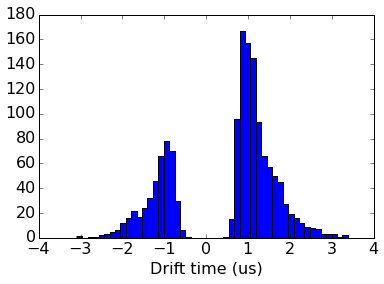

In [10]:
##
# Make your plots!
##
plt.hist(events['drift_time']/1000, bins=50)
plt.xlabel('Drift time (us)')
plt.show()

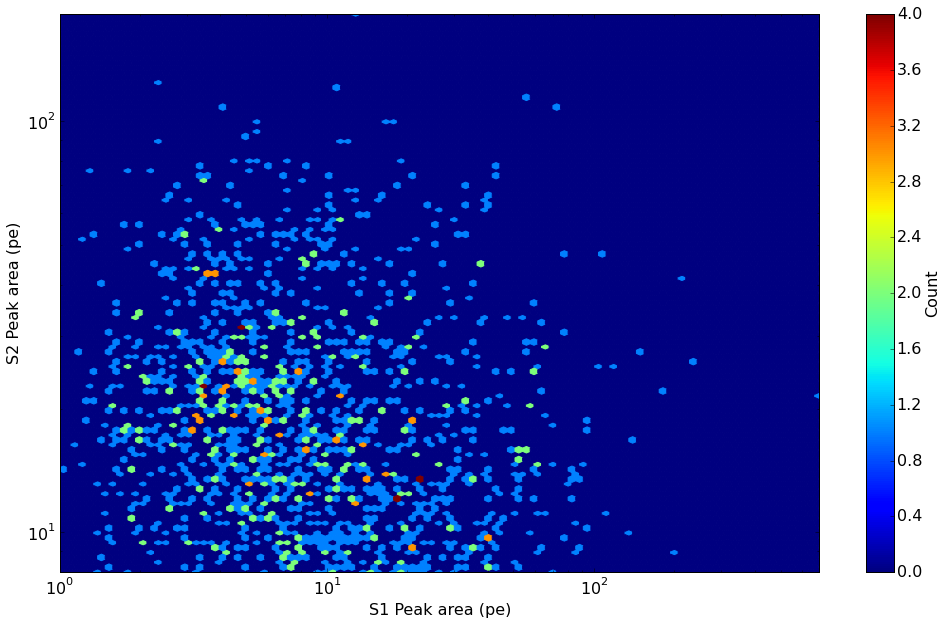

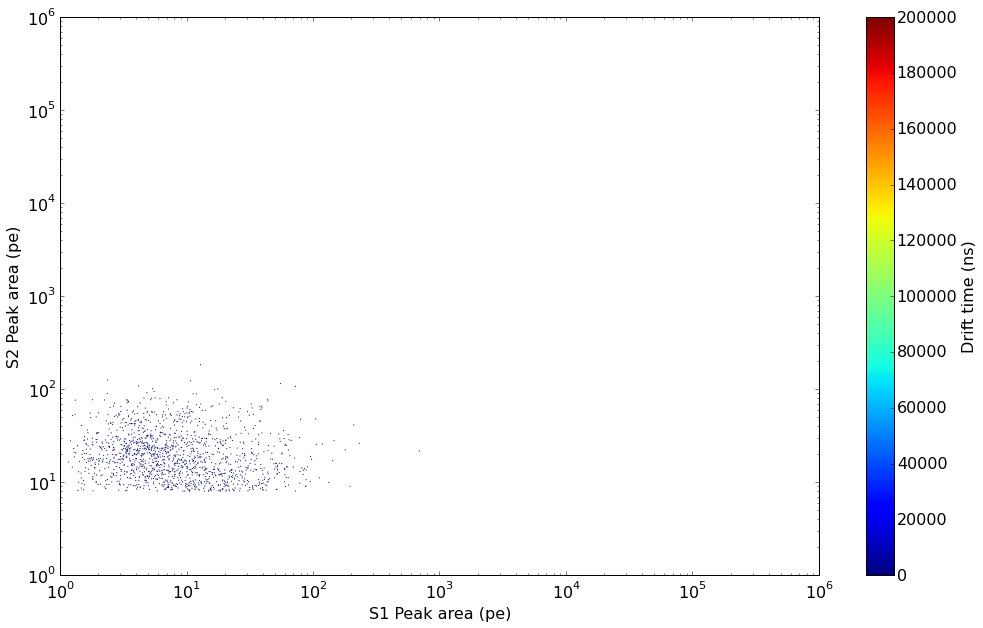

In [11]:
##
# You can also use some pre-made plotting code, if you don't want to do anything too fancy
##
from nice_plots import ColoredScatterPlot, DensityPlot

DensityPlot(events, dataset_name='events', x='s1_area', y='s2_area').show()
ColoredScatterPlot(events, dataset_name='events', x='s1_area', y='s2_area', z='drift_time').show()

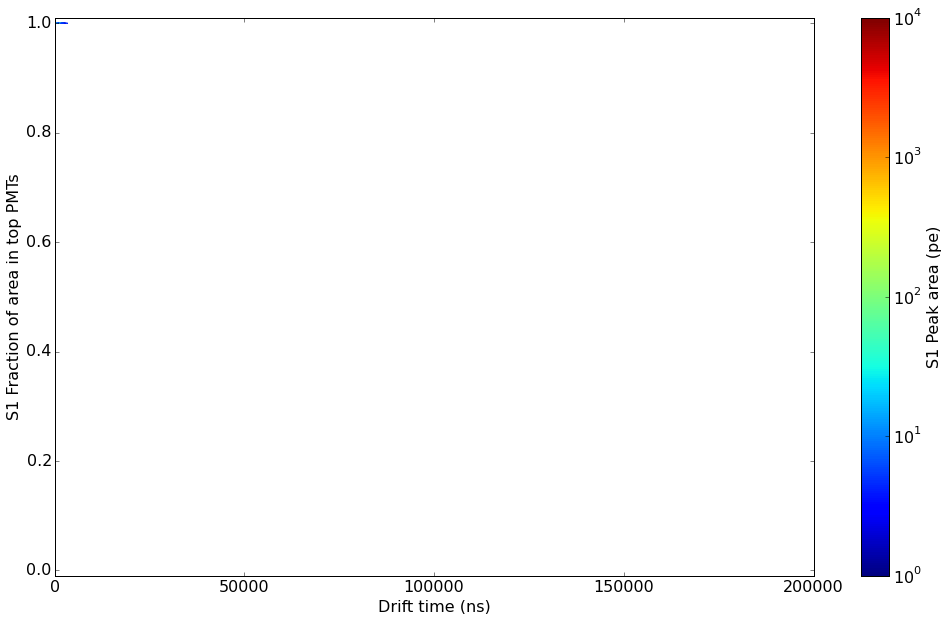

In [12]:
ColoredScatterPlot(events, dataset_name='events', 
          x='drift_time', y='s1_area_fraction_top', z='s1_area', 
          z_range=(1,10**4),
          ).show()

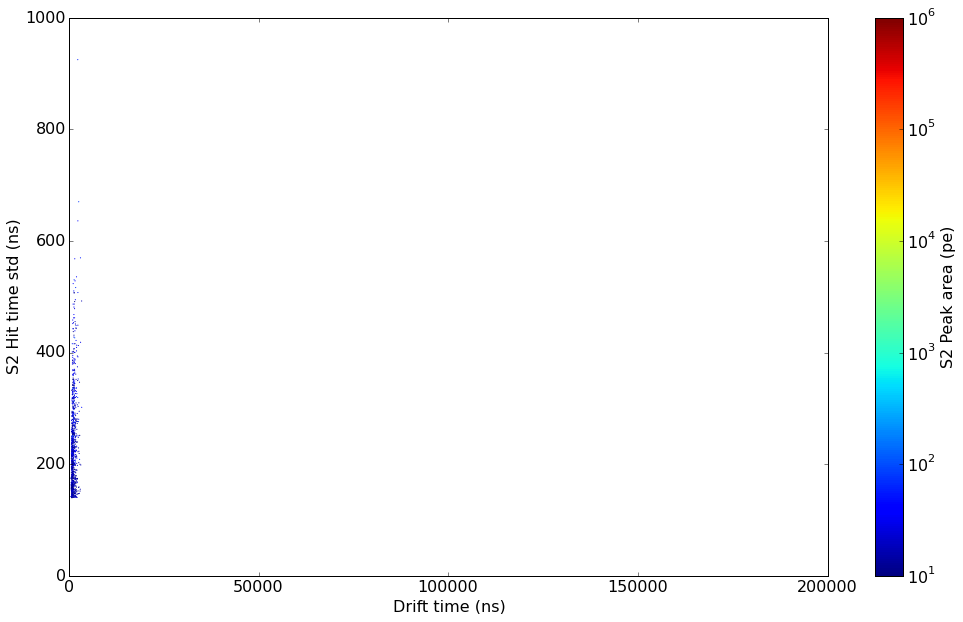

In [13]:
ColoredScatterPlot(events, dataset_name='events', 
          x='drift_time', y='s2_hit_time_std', z='s2_area',
          z_range=(10,10**6),
          y_range=(0, 1000)).show()

In [14]:
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(matplotlib.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))

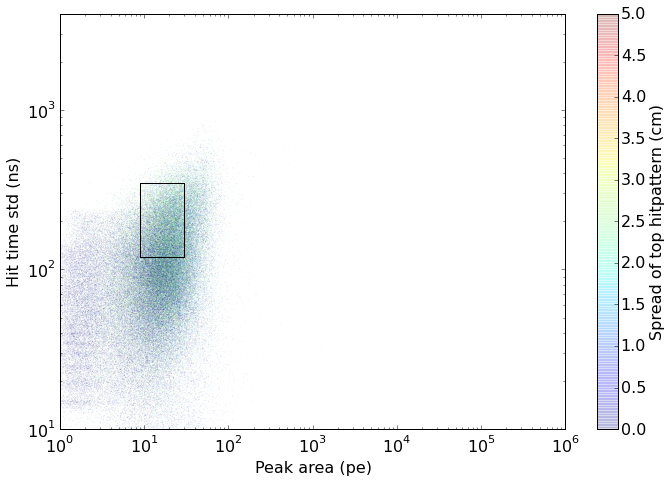

In [15]:
# This is a very different plot - each point is one PEAK in ANY event (even events without S1s or S2s)
# You can use plots like these for peak classification development
plt.figure(figsize=(10,7))
ColoredScatterPlot(peaks, dataset_name='peaks', 
          x='area', y='hit_time_std', z='top_hitpattern_spread',
          grainalpha=0.15, grainsize=2, z_range=(0,5), y_logscale=True,
          ).plot()
# Data selection for single electrons:
draw_box((9, 30), (120, 350), edgecolor="black", fill=False)
plt.tight_layout()

In [16]:
type(peaks)

numpy.ndarray

In [17]:
import pandas

In [26]:
#pandas.DataFrame(peaks[["area","index_of_maximum","does_channel_contribute"]])
peaks["does_channel_contribute"]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False,  True, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False,  True, False],
       [ True, False,  True, ..., False, False, False]], dtype=bool)